In [1]:
# パッケージのimport
import math
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from PIL import Image
from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [9]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)
        
        return out
        

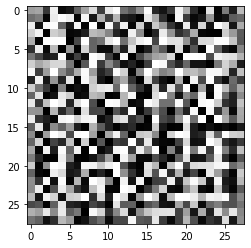

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

input_z = torch.randn(2, 20)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()

plt.imshow(img_transformed, 'gray')
plt.show()

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last2 = nn.Linear(1024, 1)
    
    def forward(self, x, z):
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)
        
        x_out = x_out.view(-1, 64*7*7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        feature = out
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last2(out)
        
        return out, feature

In [17]:
# 動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.5268],
        [0.4850]], grad_fn=<SigmoidBackward>)


In [18]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Linear(128 * 7 * 7, z_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(-1, 128*7*7)
        out = self.last(out)
        
        return out


In [19]:
# 動作確認
E = Encoder(z_dim=20)

# 入力する画像データ
x = fake_images  # fake_imagesは上のGで作成したもの

# 画像からzをEncode
z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.2901, -0.1702, -0.3266, -0.3019, -0.1141,  0.1271, -0.1139,  0.2098,
         -0.5192,  0.4571, -0.2458, -0.0705,  0.5760, -0.3078,  0.3714,  1.0302,
         -0.2951,  0.5073, -0.1008, -0.1994],
        [-0.6764, -0.2299,  0.0273,  0.1200, -0.4154, -0.5571, -0.4668, -0.8338,
         -0.1709,  0.3615,  0.3280,  0.7570,  0.3471, -0.1199,  0.0314, -0.3060,
          0.0769, -0.9269, -0.1325,  0.3957]], grad_fn=<AddmmBackward>)


In [20]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [21]:
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    def __call__(self, img):
        return self.data_transform(img)

In [22]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [23]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 28, 28])


In [35]:
def train_model(G, D, E, dataloader, num_epochs):
    
    device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device: ", device)
    
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])
    
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    z_dim = 20
    mini_batch_size = 64
    
    G.to(device)
    E.to(device)
    D.to(device)
    
    G.train()
    E.train()
    D.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')
        
        for img in dataloader:
            if img.size()[0] == 1:
                continuei
                
            mini_batch_size = img.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            img = img.to(device)
            
            z_out_real = E(img)
            d_out_real, _ = D(img, z_out_real)
            
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            z_out_real = E(img)
            d_out_real, _ = D(img, z_out_real)
            e_loss = criterion(d_out_real.view(-1), label_fake)
            
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1            

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E

In [36]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    with torch.no_grad():
        if classname.find('Conv') != -1:
            # conv2dとConvTranspose2dの初期化
            nn.init.normal_(m.weight, 0.0, 0.02)
            nn.init.constant_(m.bias, 0)
        elif classname.find('BatchNorm') != -1:
            # BatchNorm2dの初期化
            nn.init.normal_(m.weight, 0.0, 0.02)
            nn.init.constant_(m.bias, 0)
        elif classname.find('Linear') != -1:
            # 全結合層Linearの初期化
            m.bias.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [37]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

using device:  cuda:0
-------------
Epoch 0/1500
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1503 ||Epoch_G_Loss:0.0771 ||Epoch_E_Loss:0.0769
timer:  0.2557 sec.
-------------
Epoch 1/1500
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1461 ||Epoch_G_Loss:0.0795 ||Epoch_E_Loss:0.0786
timer:  0.1990 sec.
-------------
Epoch 2/1500
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1421 ||Epoch_G_Loss:0.0813 ||Epoch_E_Loss:0.0808
timer:  0.1998 sec.
-------------
Epoch 3/1500
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1377 ||Epoch_G_Loss:0.0835 ||Epoch_E_Loss:0.0844
timer:  0.1752 sec.
-------------
Epoch 4/1500
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1333 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.0873
timer:  0.1780 sec.
-------------
Epoch 5/1500
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1316 ||Epoch_G_Loss:0.0867 ||Epoch_E_Loss:0.0885
timer:  0.1764 sec.
-------------
Epoch 6/1500
---

-------------
epoch 51 || Epoch_D_Loss:0.0097 ||Epoch_G_Loss:0.3674 ||Epoch_E_Loss:0.3763
timer:  0.1979 sec.
-------------
Epoch 52/1500
-------------
（train）
-------------
epoch 52 || Epoch_D_Loss:0.0082 ||Epoch_G_Loss:0.3703 ||Epoch_E_Loss:0.3948
timer:  0.1740 sec.
-------------
Epoch 53/1500
-------------
（train）
-------------
epoch 53 || Epoch_D_Loss:0.0090 ||Epoch_G_Loss:0.3819 ||Epoch_E_Loss:0.3827
timer:  0.1572 sec.
-------------
Epoch 54/1500
-------------
（train）
-------------
epoch 54 || Epoch_D_Loss:0.0089 ||Epoch_G_Loss:0.3791 ||Epoch_E_Loss:0.3774
timer:  0.1758 sec.
-------------
Epoch 55/1500
-------------
（train）
-------------
epoch 55 || Epoch_D_Loss:0.0108 ||Epoch_G_Loss:0.3754 ||Epoch_E_Loss:0.3528
timer:  0.1735 sec.
-------------
Epoch 56/1500
-------------
（train）
-------------
epoch 56 || Epoch_D_Loss:0.0120 ||Epoch_G_Loss:0.3709 ||Epoch_E_Loss:0.3385
timer:  0.1754 sec.
-------------
Epoch 57/1500
-------------
（train）
-------------
epoch 57 || Epoch_D_Loss:0

-------------
epoch 103 || Epoch_D_Loss:0.0258 ||Epoch_G_Loss:0.3095 ||Epoch_E_Loss:0.3134
timer:  0.2009 sec.
-------------
Epoch 104/1500
-------------
（train）
-------------
epoch 104 || Epoch_D_Loss:0.0227 ||Epoch_G_Loss:0.3355 ||Epoch_E_Loss:0.3244
timer:  0.1763 sec.
-------------
Epoch 105/1500
-------------
（train）
-------------
epoch 105 || Epoch_D_Loss:0.0332 ||Epoch_G_Loss:0.2979 ||Epoch_E_Loss:0.2941
timer:  0.1721 sec.
-------------
Epoch 106/1500
-------------
（train）
-------------
epoch 106 || Epoch_D_Loss:0.0532 ||Epoch_G_Loss:0.2529 ||Epoch_E_Loss:0.2579
timer:  0.1750 sec.
-------------
Epoch 107/1500
-------------
（train）
-------------
epoch 107 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.2402 ||Epoch_E_Loss:0.2821
timer:  0.1974 sec.
-------------
Epoch 108/1500
-------------
（train）
-------------
epoch 108 || Epoch_D_Loss:0.0387 ||Epoch_G_Loss:0.2636 ||Epoch_E_Loss:0.2836
timer:  0.1602 sec.
-------------
Epoch 109/1500
-------------
（train）
-------------
epoch 109 || E

-------------
epoch 154 || Epoch_D_Loss:0.0611 ||Epoch_G_Loss:0.2197 ||Epoch_E_Loss:0.2262
timer:  0.1735 sec.
-------------
Epoch 155/1500
-------------
（train）
-------------
epoch 155 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.2223 ||Epoch_E_Loss:0.2056
timer:  0.1752 sec.
-------------
Epoch 156/1500
-------------
（train）
-------------
epoch 156 || Epoch_D_Loss:0.0808 ||Epoch_G_Loss:0.2031 ||Epoch_E_Loss:0.2052
timer:  0.1806 sec.
-------------
Epoch 157/1500
-------------
（train）
-------------
epoch 157 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.2058 ||Epoch_E_Loss:0.1960
timer:  0.1758 sec.
-------------
Epoch 158/1500
-------------
（train）
-------------
epoch 158 || Epoch_D_Loss:0.0740 ||Epoch_G_Loss:0.1973 ||Epoch_E_Loss:0.1985
timer:  0.1764 sec.
-------------
Epoch 159/1500
-------------
（train）
-------------
epoch 159 || Epoch_D_Loss:0.0759 ||Epoch_G_Loss:0.2135 ||Epoch_E_Loss:0.1935
timer:  0.1813 sec.
-------------
Epoch 160/1500
-------------
（train）
-------------
epoch 160 || E

-------------
epoch 206 || Epoch_D_Loss:0.1090 ||Epoch_G_Loss:0.1339 ||Epoch_E_Loss:0.1486
timer:  0.1727 sec.
-------------
Epoch 207/1500
-------------
（train）
-------------
epoch 207 || Epoch_D_Loss:0.1215 ||Epoch_G_Loss:0.1548 ||Epoch_E_Loss:0.1343
timer:  0.1741 sec.
-------------
Epoch 208/1500
-------------
（train）
-------------
epoch 208 || Epoch_D_Loss:0.1101 ||Epoch_G_Loss:0.1578 ||Epoch_E_Loss:0.1496
timer:  0.1761 sec.
-------------
Epoch 209/1500
-------------
（train）
-------------
epoch 209 || Epoch_D_Loss:0.1131 ||Epoch_G_Loss:0.1572 ||Epoch_E_Loss:0.1400
timer:  0.1611 sec.
-------------
Epoch 210/1500
-------------
（train）
-------------
epoch 210 || Epoch_D_Loss:0.1176 ||Epoch_G_Loss:0.1572 ||Epoch_E_Loss:0.1411
timer:  0.1588 sec.
-------------
Epoch 211/1500
-------------
（train）
-------------
epoch 211 || Epoch_D_Loss:0.1098 ||Epoch_G_Loss:0.1577 ||Epoch_E_Loss:0.1445
timer:  0.1767 sec.
-------------
Epoch 212/1500
-------------
（train）
-------------
epoch 212 || E

-------------
epoch 258 || Epoch_D_Loss:0.1144 ||Epoch_G_Loss:0.1468 ||Epoch_E_Loss:0.1441
timer:  0.1761 sec.
-------------
Epoch 259/1500
-------------
（train）
-------------
epoch 259 || Epoch_D_Loss:0.1283 ||Epoch_G_Loss:0.1360 ||Epoch_E_Loss:0.1374
timer:  0.1795 sec.
-------------
Epoch 260/1500
-------------
（train）
-------------
epoch 260 || Epoch_D_Loss:0.1340 ||Epoch_G_Loss:0.1350 ||Epoch_E_Loss:0.1350
timer:  0.1722 sec.
-------------
Epoch 261/1500
-------------
（train）
-------------
epoch 261 || Epoch_D_Loss:0.1157 ||Epoch_G_Loss:0.1420 ||Epoch_E_Loss:0.1469
timer:  0.1751 sec.
-------------
Epoch 262/1500
-------------
（train）
-------------
epoch 262 || Epoch_D_Loss:0.1141 ||Epoch_G_Loss:0.1443 ||Epoch_E_Loss:0.1452
timer:  0.1845 sec.
-------------
Epoch 263/1500
-------------
（train）
-------------
epoch 263 || Epoch_D_Loss:0.1119 ||Epoch_G_Loss:0.1325 ||Epoch_E_Loss:0.1511
timer:  0.1774 sec.
-------------
Epoch 264/1500
-------------
（train）
-------------
epoch 264 || E

-------------
epoch 310 || Epoch_D_Loss:0.1165 ||Epoch_G_Loss:0.1294 ||Epoch_E_Loss:0.1413
timer:  0.1611 sec.
-------------
Epoch 311/1500
-------------
（train）
-------------
epoch 311 || Epoch_D_Loss:0.1000 ||Epoch_G_Loss:0.1420 ||Epoch_E_Loss:0.1501
timer:  0.1586 sec.
-------------
Epoch 312/1500
-------------
（train）
-------------
epoch 312 || Epoch_D_Loss:0.1134 ||Epoch_G_Loss:0.1344 ||Epoch_E_Loss:0.1380
timer:  0.1641 sec.
-------------
Epoch 313/1500
-------------
（train）
-------------
epoch 313 || Epoch_D_Loss:0.1326 ||Epoch_G_Loss:0.1167 ||Epoch_E_Loss:0.1278
timer:  0.1654 sec.
-------------
Epoch 314/1500
-------------
（train）
-------------
epoch 314 || Epoch_D_Loss:0.1530 ||Epoch_G_Loss:0.1206 ||Epoch_E_Loss:0.1155
timer:  0.1698 sec.
-------------
Epoch 315/1500
-------------
（train）
-------------
epoch 315 || Epoch_D_Loss:0.1490 ||Epoch_G_Loss:0.1135 ||Epoch_E_Loss:0.1261
timer:  0.1768 sec.
-------------
Epoch 316/1500
-------------
（train）
-------------
epoch 316 || E

-------------
epoch 362 || Epoch_D_Loss:0.1296 ||Epoch_G_Loss:0.1118 ||Epoch_E_Loss:0.1227
timer:  0.1533 sec.
-------------
Epoch 363/1500
-------------
（train）
-------------
epoch 363 || Epoch_D_Loss:0.1445 ||Epoch_G_Loss:0.1072 ||Epoch_E_Loss:0.1151
timer:  0.1535 sec.
-------------
Epoch 364/1500
-------------
（train）
-------------
epoch 364 || Epoch_D_Loss:0.1535 ||Epoch_G_Loss:0.1051 ||Epoch_E_Loss:0.1112
timer:  0.1534 sec.
-------------
Epoch 365/1500
-------------
（train）
-------------
epoch 365 || Epoch_D_Loss:0.1523 ||Epoch_G_Loss:0.0932 ||Epoch_E_Loss:0.1145
timer:  0.1552 sec.
-------------
Epoch 366/1500
-------------
（train）
-------------
epoch 366 || Epoch_D_Loss:0.1588 ||Epoch_G_Loss:0.0973 ||Epoch_E_Loss:0.1122
timer:  0.1536 sec.
-------------
Epoch 367/1500
-------------
（train）
-------------
epoch 367 || Epoch_D_Loss:0.1538 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1144
timer:  0.1536 sec.
-------------
Epoch 368/1500
-------------
（train）
-------------
epoch 368 || E

-------------
epoch 414 || Epoch_D_Loss:0.1695 ||Epoch_G_Loss:0.0831 ||Epoch_E_Loss:0.1097
timer:  0.1566 sec.
-------------
Epoch 415/1500
-------------
（train）
-------------
epoch 415 || Epoch_D_Loss:0.1739 ||Epoch_G_Loss:0.0783 ||Epoch_E_Loss:0.1008
timer:  0.1563 sec.
-------------
Epoch 416/1500
-------------
（train）
-------------
epoch 416 || Epoch_D_Loss:0.1858 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0939
timer:  0.1589 sec.
-------------
Epoch 417/1500
-------------
（train）
-------------
epoch 417 || Epoch_D_Loss:0.1800 ||Epoch_G_Loss:0.0798 ||Epoch_E_Loss:0.0966
timer:  0.1570 sec.
-------------
Epoch 418/1500
-------------
（train）
-------------
epoch 418 || Epoch_D_Loss:0.1700 ||Epoch_G_Loss:0.0883 ||Epoch_E_Loss:0.0987
timer:  0.1566 sec.
-------------
Epoch 419/1500
-------------
（train）
-------------
epoch 419 || Epoch_D_Loss:0.1655 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.1042
timer:  0.1573 sec.
-------------
Epoch 420/1500
-------------
（train）
-------------
epoch 420 || E

-------------
epoch 466 || Epoch_D_Loss:0.1647 ||Epoch_G_Loss:0.0847 ||Epoch_E_Loss:0.1009
timer:  0.1597 sec.
-------------
Epoch 467/1500
-------------
（train）
-------------
epoch 467 || Epoch_D_Loss:0.1662 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.1066
timer:  0.1575 sec.
-------------
Epoch 468/1500
-------------
（train）
-------------
epoch 468 || Epoch_D_Loss:0.1548 ||Epoch_G_Loss:0.0992 ||Epoch_E_Loss:0.1114
timer:  0.1570 sec.
-------------
Epoch 469/1500
-------------
（train）
-------------
epoch 469 || Epoch_D_Loss:0.1467 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.1180
timer:  0.1562 sec.
-------------
Epoch 470/1500
-------------
（train）
-------------
epoch 470 || Epoch_D_Loss:0.1583 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1141
timer:  0.1575 sec.
-------------
Epoch 471/1500
-------------
（train）
-------------
epoch 471 || Epoch_D_Loss:0.1588 ||Epoch_G_Loss:0.0880 ||Epoch_E_Loss:0.1132
timer:  0.1553 sec.
-------------
Epoch 472/1500
-------------
（train）
-------------
epoch 472 || E

-------------
epoch 518 || Epoch_D_Loss:0.1237 ||Epoch_G_Loss:0.0984 ||Epoch_E_Loss:0.1091
timer:  0.1564 sec.
-------------
Epoch 519/1500
-------------
（train）
-------------
epoch 519 || Epoch_D_Loss:0.1212 ||Epoch_G_Loss:0.1034 ||Epoch_E_Loss:0.1156
timer:  0.1565 sec.
-------------
Epoch 520/1500
-------------
（train）
-------------
epoch 520 || Epoch_D_Loss:0.1314 ||Epoch_G_Loss:0.1002 ||Epoch_E_Loss:0.1088
timer:  0.1588 sec.
-------------
Epoch 521/1500
-------------
（train）
-------------
epoch 521 || Epoch_D_Loss:0.1417 ||Epoch_G_Loss:0.0924 ||Epoch_E_Loss:0.1017
timer:  0.1579 sec.
-------------
Epoch 522/1500
-------------
（train）
-------------
epoch 522 || Epoch_D_Loss:0.1381 ||Epoch_G_Loss:0.0929 ||Epoch_E_Loss:0.1029
timer:  0.1565 sec.
-------------
Epoch 523/1500
-------------
（train）
-------------
epoch 523 || Epoch_D_Loss:0.1322 ||Epoch_G_Loss:0.0964 ||Epoch_E_Loss:0.1043
timer:  0.1563 sec.
-------------
Epoch 524/1500
-------------
（train）
-------------
epoch 524 || E

-------------
epoch 570 || Epoch_D_Loss:0.1617 ||Epoch_G_Loss:0.0823 ||Epoch_E_Loss:0.1018
timer:  0.1565 sec.
-------------
Epoch 571/1500
-------------
（train）
-------------
epoch 571 || Epoch_D_Loss:0.1574 ||Epoch_G_Loss:0.0813 ||Epoch_E_Loss:0.1017
timer:  0.1577 sec.
-------------
Epoch 572/1500
-------------
（train）
-------------
epoch 572 || Epoch_D_Loss:0.1544 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.1010
timer:  0.1565 sec.
-------------
Epoch 573/1500
-------------
（train）
-------------
epoch 573 || Epoch_D_Loss:0.1607 ||Epoch_G_Loss:0.0759 ||Epoch_E_Loss:0.1025
timer:  0.1567 sec.
-------------
Epoch 574/1500
-------------
（train）
-------------
epoch 574 || Epoch_D_Loss:0.1624 ||Epoch_G_Loss:0.0887 ||Epoch_E_Loss:0.0979
timer:  0.1580 sec.
-------------
Epoch 575/1500
-------------
（train）
-------------
epoch 575 || Epoch_D_Loss:0.1206 ||Epoch_G_Loss:0.1057 ||Epoch_E_Loss:0.1354
timer:  0.1564 sec.
-------------
Epoch 576/1500
-------------
（train）
-------------
epoch 576 || E

-------------
epoch 622 || Epoch_D_Loss:0.1303 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1167
timer:  0.1565 sec.
-------------
Epoch 623/1500
-------------
（train）
-------------
epoch 623 || Epoch_D_Loss:0.1459 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.1091
timer:  0.1546 sec.
-------------
Epoch 624/1500
-------------
（train）
-------------
epoch 624 || Epoch_D_Loss:0.1296 ||Epoch_G_Loss:0.0996 ||Epoch_E_Loss:0.1190
timer:  0.1545 sec.
-------------
Epoch 625/1500
-------------
（train）
-------------
epoch 625 || Epoch_D_Loss:0.1252 ||Epoch_G_Loss:0.1020 ||Epoch_E_Loss:0.1227
timer:  0.1557 sec.
-------------
Epoch 626/1500
-------------
（train）
-------------
epoch 626 || Epoch_D_Loss:0.1304 ||Epoch_G_Loss:0.1049 ||Epoch_E_Loss:0.1124
timer:  0.1552 sec.
-------------
Epoch 627/1500
-------------
（train）
-------------
epoch 627 || Epoch_D_Loss:0.1292 ||Epoch_G_Loss:0.0923 ||Epoch_E_Loss:0.1191
timer:  0.1551 sec.
-------------
Epoch 628/1500
-------------
（train）
-------------
epoch 628 || E

-------------
epoch 674 || Epoch_D_Loss:0.1623 ||Epoch_G_Loss:0.0827 ||Epoch_E_Loss:0.0965
timer:  0.1537 sec.
-------------
Epoch 675/1500
-------------
（train）
-------------
epoch 675 || Epoch_D_Loss:0.1590 ||Epoch_G_Loss:0.0875 ||Epoch_E_Loss:0.0993
timer:  0.1534 sec.
-------------
Epoch 676/1500
-------------
（train）
-------------
epoch 676 || Epoch_D_Loss:0.1506 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.1008
timer:  0.1554 sec.
-------------
Epoch 677/1500
-------------
（train）
-------------
epoch 677 || Epoch_D_Loss:0.1397 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1091
timer:  0.1538 sec.
-------------
Epoch 678/1500
-------------
（train）
-------------
epoch 678 || Epoch_D_Loss:0.1279 ||Epoch_G_Loss:0.1117 ||Epoch_E_Loss:0.1131
timer:  0.1540 sec.
-------------
Epoch 679/1500
-------------
（train）
-------------
epoch 679 || Epoch_D_Loss:0.1144 ||Epoch_G_Loss:0.1115 ||Epoch_E_Loss:0.1276
timer:  0.1537 sec.
-------------
Epoch 680/1500
-------------
（train）
-------------
epoch 680 || E

-------------
epoch 726 || Epoch_D_Loss:0.1077 ||Epoch_G_Loss:0.1123 ||Epoch_E_Loss:0.1222
timer:  0.1595 sec.
-------------
Epoch 727/1500
-------------
（train）
-------------
epoch 727 || Epoch_D_Loss:0.1080 ||Epoch_G_Loss:0.1089 ||Epoch_E_Loss:0.1202
timer:  0.1567 sec.
-------------
Epoch 728/1500
-------------
（train）
-------------
epoch 728 || Epoch_D_Loss:0.1193 ||Epoch_G_Loss:0.1096 ||Epoch_E_Loss:0.1174
timer:  0.1565 sec.
-------------
Epoch 729/1500
-------------
（train）
-------------
epoch 729 || Epoch_D_Loss:0.1359 ||Epoch_G_Loss:0.0900 ||Epoch_E_Loss:0.1046
timer:  0.1582 sec.
-------------
Epoch 730/1500
-------------
（train）
-------------
epoch 730 || Epoch_D_Loss:0.1434 ||Epoch_G_Loss:0.0868 ||Epoch_E_Loss:0.0983
timer:  0.1581 sec.
-------------
Epoch 731/1500
-------------
（train）
-------------
epoch 731 || Epoch_D_Loss:0.1404 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.1020
timer:  0.1567 sec.
-------------
Epoch 732/1500
-------------
（train）
-------------
epoch 732 || E

-------------
epoch 778 || Epoch_D_Loss:0.1346 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1116
timer:  0.1576 sec.
-------------
Epoch 779/1500
-------------
（train）
-------------
epoch 779 || Epoch_D_Loss:0.1379 ||Epoch_G_Loss:0.0998 ||Epoch_E_Loss:0.1181
timer:  0.1569 sec.
-------------
Epoch 780/1500
-------------
（train）
-------------
epoch 780 || Epoch_D_Loss:0.1218 ||Epoch_G_Loss:0.1093 ||Epoch_E_Loss:0.1195
timer:  0.1589 sec.
-------------
Epoch 781/1500
-------------
（train）
-------------
epoch 781 || Epoch_D_Loss:0.1219 ||Epoch_G_Loss:0.1071 ||Epoch_E_Loss:0.1282
timer:  0.1570 sec.
-------------
Epoch 782/1500
-------------
（train）
-------------
epoch 782 || Epoch_D_Loss:0.1207 ||Epoch_G_Loss:0.1104 ||Epoch_E_Loss:0.1228
timer:  0.1565 sec.
-------------
Epoch 783/1500
-------------
（train）
-------------
epoch 783 || Epoch_D_Loss:0.1187 ||Epoch_G_Loss:0.1053 ||Epoch_E_Loss:0.1225
timer:  0.1586 sec.
-------------
Epoch 784/1500
-------------
（train）
-------------
epoch 784 || E

-------------
epoch 830 || Epoch_D_Loss:0.1496 ||Epoch_G_Loss:0.0955 ||Epoch_E_Loss:0.1090
timer:  0.1751 sec.
-------------
Epoch 831/1500
-------------
（train）
-------------
epoch 831 || Epoch_D_Loss:0.1444 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1117
timer:  0.1767 sec.
-------------
Epoch 832/1500
-------------
（train）
-------------
epoch 832 || Epoch_D_Loss:0.1220 ||Epoch_G_Loss:0.1114 ||Epoch_E_Loss:0.1239
timer:  0.1813 sec.
-------------
Epoch 833/1500
-------------
（train）
-------------
epoch 833 || Epoch_D_Loss:0.1096 ||Epoch_G_Loss:0.1300 ||Epoch_E_Loss:0.1412
timer:  0.1577 sec.
-------------
Epoch 834/1500
-------------
（train）
-------------
epoch 834 || Epoch_D_Loss:0.1162 ||Epoch_G_Loss:0.1210 ||Epoch_E_Loss:0.1272
timer:  0.1603 sec.
-------------
Epoch 835/1500
-------------
（train）
-------------
epoch 835 || Epoch_D_Loss:0.1352 ||Epoch_G_Loss:0.1022 ||Epoch_E_Loss:0.1174
timer:  0.1845 sec.
-------------
Epoch 836/1500
-------------
（train）
-------------
epoch 836 || E

-------------
epoch 882 || Epoch_D_Loss:0.1208 ||Epoch_G_Loss:0.1113 ||Epoch_E_Loss:0.1180
timer:  0.1888 sec.
-------------
Epoch 883/1500
-------------
（train）
-------------
epoch 883 || Epoch_D_Loss:0.1268 ||Epoch_G_Loss:0.1179 ||Epoch_E_Loss:0.1186
timer:  0.1757 sec.
-------------
Epoch 884/1500
-------------
（train）
-------------
epoch 884 || Epoch_D_Loss:0.1122 ||Epoch_G_Loss:0.1188 ||Epoch_E_Loss:0.1280
timer:  0.1785 sec.
-------------
Epoch 885/1500
-------------
（train）
-------------
epoch 885 || Epoch_D_Loss:0.1058 ||Epoch_G_Loss:0.1174 ||Epoch_E_Loss:0.1283
timer:  0.2058 sec.
-------------
Epoch 886/1500
-------------
（train）
-------------
epoch 886 || Epoch_D_Loss:0.1125 ||Epoch_G_Loss:0.1248 ||Epoch_E_Loss:0.1221
timer:  0.1753 sec.
-------------
Epoch 887/1500
-------------
（train）
-------------
epoch 887 || Epoch_D_Loss:0.1119 ||Epoch_G_Loss:0.1206 ||Epoch_E_Loss:0.1264
timer:  0.1760 sec.
-------------
Epoch 888/1500
-------------
（train）
-------------
epoch 888 || E

-------------
epoch 933 || Epoch_D_Loss:0.1132 ||Epoch_G_Loss:0.1236 ||Epoch_E_Loss:0.1212
timer:  0.1740 sec.
-------------
Epoch 934/1500
-------------
（train）
-------------
epoch 934 || Epoch_D_Loss:0.1136 ||Epoch_G_Loss:0.1198 ||Epoch_E_Loss:0.1302
timer:  0.1786 sec.
-------------
Epoch 935/1500
-------------
（train）
-------------
epoch 935 || Epoch_D_Loss:0.1087 ||Epoch_G_Loss:0.1224 ||Epoch_E_Loss:0.1273
timer:  0.1639 sec.
-------------
Epoch 936/1500
-------------
（train）
-------------
epoch 936 || Epoch_D_Loss:0.1177 ||Epoch_G_Loss:0.1149 ||Epoch_E_Loss:0.1396
timer:  0.1541 sec.
-------------
Epoch 937/1500
-------------
（train）
-------------
epoch 937 || Epoch_D_Loss:0.1228 ||Epoch_G_Loss:0.1294 ||Epoch_E_Loss:0.1204
timer:  0.1795 sec.
-------------
Epoch 938/1500
-------------
（train）
-------------
epoch 938 || Epoch_D_Loss:0.1160 ||Epoch_G_Loss:0.1106 ||Epoch_E_Loss:0.1283
timer:  0.1774 sec.
-------------
Epoch 939/1500
-------------
（train）
-------------
epoch 939 || E

-------------
epoch 985 || Epoch_D_Loss:0.1106 ||Epoch_G_Loss:0.1172 ||Epoch_E_Loss:0.1314
timer:  0.1811 sec.
-------------
Epoch 986/1500
-------------
（train）
-------------
epoch 986 || Epoch_D_Loss:0.1020 ||Epoch_G_Loss:0.1320 ||Epoch_E_Loss:0.1353
timer:  0.1770 sec.
-------------
Epoch 987/1500
-------------
（train）
-------------
epoch 987 || Epoch_D_Loss:0.1015 ||Epoch_G_Loss:0.1280 ||Epoch_E_Loss:0.1358
timer:  0.1768 sec.
-------------
Epoch 988/1500
-------------
（train）
-------------
epoch 988 || Epoch_D_Loss:0.0992 ||Epoch_G_Loss:0.1281 ||Epoch_E_Loss:0.1385
timer:  0.1768 sec.
-------------
Epoch 989/1500
-------------
（train）
-------------
epoch 989 || Epoch_D_Loss:0.1044 ||Epoch_G_Loss:0.1385 ||Epoch_E_Loss:0.1323
timer:  0.1765 sec.
-------------
Epoch 990/1500
-------------
（train）
-------------
epoch 990 || Epoch_D_Loss:0.1071 ||Epoch_G_Loss:0.1261 ||Epoch_E_Loss:0.1374
timer:  0.1750 sec.
-------------
Epoch 991/1500
-------------
（train）
-------------
epoch 991 || E

-------------
epoch 1037 || Epoch_D_Loss:0.0889 ||Epoch_G_Loss:0.1411 ||Epoch_E_Loss:0.1542
timer:  0.1700 sec.
-------------
Epoch 1038/1500
-------------
（train）
-------------
epoch 1038 || Epoch_D_Loss:0.0954 ||Epoch_G_Loss:0.1273 ||Epoch_E_Loss:0.1420
timer:  0.1584 sec.
-------------
Epoch 1039/1500
-------------
（train）
-------------
epoch 1039 || Epoch_D_Loss:0.1177 ||Epoch_G_Loss:0.1231 ||Epoch_E_Loss:0.1289
timer:  0.1713 sec.
-------------
Epoch 1040/1500
-------------
（train）
-------------
epoch 1040 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.1163 ||Epoch_E_Loss:0.1267
timer:  0.1758 sec.
-------------
Epoch 1041/1500
-------------
（train）
-------------
epoch 1041 || Epoch_D_Loss:0.1197 ||Epoch_G_Loss:0.1201 ||Epoch_E_Loss:0.1291
timer:  0.1860 sec.
-------------
Epoch 1042/1500
-------------
（train）
-------------
epoch 1042 || Epoch_D_Loss:0.1137 ||Epoch_G_Loss:0.1293 ||Epoch_E_Loss:0.1249
timer:  0.1981 sec.
-------------
Epoch 1043/1500
-------------
（train）
-------------
ep

-------------
epoch 1088 || Epoch_D_Loss:0.0969 ||Epoch_G_Loss:0.1241 ||Epoch_E_Loss:0.1512
timer:  0.1762 sec.
-------------
Epoch 1089/1500
-------------
（train）
-------------
epoch 1089 || Epoch_D_Loss:0.1065 ||Epoch_G_Loss:0.1321 ||Epoch_E_Loss:0.1302
timer:  0.1760 sec.
-------------
Epoch 1090/1500
-------------
（train）
-------------
epoch 1090 || Epoch_D_Loss:0.1040 ||Epoch_G_Loss:0.1329 ||Epoch_E_Loss:0.1398
timer:  0.1756 sec.
-------------
Epoch 1091/1500
-------------
（train）
-------------
epoch 1091 || Epoch_D_Loss:0.0986 ||Epoch_G_Loss:0.1214 ||Epoch_E_Loss:0.1456
timer:  0.1757 sec.
-------------
Epoch 1092/1500
-------------
（train）
-------------
epoch 1092 || Epoch_D_Loss:0.1057 ||Epoch_G_Loss:0.1217 ||Epoch_E_Loss:0.1330
timer:  0.1782 sec.
-------------
Epoch 1093/1500
-------------
（train）
-------------
epoch 1093 || Epoch_D_Loss:0.1102 ||Epoch_G_Loss:0.1381 ||Epoch_E_Loss:0.1332
timer:  0.1680 sec.
-------------
Epoch 1094/1500
-------------
（train）
-------------
ep

-------------
epoch 1138 || Epoch_D_Loss:0.1028 ||Epoch_G_Loss:0.1343 ||Epoch_E_Loss:0.1527
timer:  0.1737 sec.
-------------
Epoch 1139/1500
-------------
（train）
-------------
epoch 1139 || Epoch_D_Loss:0.0971 ||Epoch_G_Loss:0.1389 ||Epoch_E_Loss:0.1489
timer:  0.1574 sec.
-------------
Epoch 1140/1500
-------------
（train）
-------------
epoch 1140 || Epoch_D_Loss:0.0995 ||Epoch_G_Loss:0.1434 ||Epoch_E_Loss:0.1365
timer:  0.1607 sec.
-------------
Epoch 1141/1500
-------------
（train）
-------------
epoch 1141 || Epoch_D_Loss:0.1070 ||Epoch_G_Loss:0.1158 ||Epoch_E_Loss:0.1409
timer:  0.1823 sec.
-------------
Epoch 1142/1500
-------------
（train）
-------------
epoch 1142 || Epoch_D_Loss:0.1043 ||Epoch_G_Loss:0.1368 ||Epoch_E_Loss:0.1352
timer:  0.1794 sec.
-------------
Epoch 1143/1500
-------------
（train）
-------------
epoch 1143 || Epoch_D_Loss:0.0960 ||Epoch_G_Loss:0.1371 ||Epoch_E_Loss:0.1441
timer:  0.1755 sec.
-------------
Epoch 1144/1500
-------------
（train）
-------------
ep

-------------
epoch 1188 || Epoch_D_Loss:0.1293 ||Epoch_G_Loss:0.1201 ||Epoch_E_Loss:0.1293
timer:  0.1758 sec.
-------------
Epoch 1189/1500
-------------
（train）
-------------
epoch 1189 || Epoch_D_Loss:0.1208 ||Epoch_G_Loss:0.1335 ||Epoch_E_Loss:0.1245
timer:  0.1786 sec.
-------------
Epoch 1190/1500
-------------
（train）
-------------
epoch 1190 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1441 ||Epoch_E_Loss:0.1642
timer:  0.1795 sec.
-------------
Epoch 1191/1500
-------------
（train）
-------------
epoch 1191 || Epoch_D_Loss:0.0819 ||Epoch_G_Loss:0.1623 ||Epoch_E_Loss:0.1584
timer:  0.1779 sec.
-------------
Epoch 1192/1500
-------------
（train）
-------------
epoch 1192 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1206 ||Epoch_E_Loss:0.1678
timer:  0.1796 sec.
-------------
Epoch 1193/1500
-------------
（train）
-------------
epoch 1193 || Epoch_D_Loss:0.1233 ||Epoch_G_Loss:0.1178 ||Epoch_E_Loss:0.1222
timer:  0.1793 sec.
-------------
Epoch 1194/1500
-------------
（train）
-------------
ep

-------------
epoch 1238 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.1363 ||Epoch_E_Loss:0.1466
timer:  0.2012 sec.
-------------
Epoch 1239/1500
-------------
（train）
-------------
epoch 1239 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.1550 ||Epoch_E_Loss:0.1539
timer:  0.1874 sec.
-------------
Epoch 1240/1500
-------------
（train）
-------------
epoch 1240 || Epoch_D_Loss:0.0874 ||Epoch_G_Loss:0.1447 ||Epoch_E_Loss:0.1663
timer:  0.1920 sec.
-------------
Epoch 1241/1500
-------------
（train）
-------------
epoch 1241 || Epoch_D_Loss:0.0959 ||Epoch_G_Loss:0.1596 ||Epoch_E_Loss:0.1579
timer:  0.1697 sec.
-------------
Epoch 1242/1500
-------------
（train）
-------------
epoch 1242 || Epoch_D_Loss:0.1016 ||Epoch_G_Loss:0.1371 ||Epoch_E_Loss:0.1457
timer:  0.2000 sec.
-------------
Epoch 1243/1500
-------------
（train）
-------------
epoch 1243 || Epoch_D_Loss:0.0938 ||Epoch_G_Loss:0.1536 ||Epoch_E_Loss:0.1508
timer:  0.1768 sec.
-------------
Epoch 1244/1500
-------------
（train）
-------------
ep

-------------
epoch 1288 || Epoch_D_Loss:0.0976 ||Epoch_G_Loss:0.1563 ||Epoch_E_Loss:0.1442
timer:  0.1808 sec.
-------------
Epoch 1289/1500
-------------
（train）
-------------
epoch 1289 || Epoch_D_Loss:0.0984 ||Epoch_G_Loss:0.1380 ||Epoch_E_Loss:0.1484
timer:  0.1731 sec.
-------------
Epoch 1290/1500
-------------
（train）
-------------
epoch 1290 || Epoch_D_Loss:0.1007 ||Epoch_G_Loss:0.1304 ||Epoch_E_Loss:0.1511
timer:  0.1845 sec.
-------------
Epoch 1291/1500
-------------
（train）
-------------
epoch 1291 || Epoch_D_Loss:0.0960 ||Epoch_G_Loss:0.1301 ||Epoch_E_Loss:0.1517
timer:  0.1971 sec.
-------------
Epoch 1292/1500
-------------
（train）
-------------
epoch 1292 || Epoch_D_Loss:0.0906 ||Epoch_G_Loss:0.1471 ||Epoch_E_Loss:0.1559
timer:  0.1735 sec.
-------------
Epoch 1293/1500
-------------
（train）
-------------
epoch 1293 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.1602 ||Epoch_E_Loss:0.1712
timer:  0.1717 sec.
-------------
Epoch 1294/1500
-------------
（train）
-------------
ep

-------------
epoch 1338 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.1652 ||Epoch_E_Loss:0.1723
timer:  0.1782 sec.
-------------
Epoch 1339/1500
-------------
（train）
-------------
epoch 1339 || Epoch_D_Loss:0.0931 ||Epoch_G_Loss:0.1581 ||Epoch_E_Loss:0.1588
timer:  0.1781 sec.
-------------
Epoch 1340/1500
-------------
（train）
-------------
epoch 1340 || Epoch_D_Loss:0.0977 ||Epoch_G_Loss:0.1433 ||Epoch_E_Loss:0.1584
timer:  0.1777 sec.
-------------
Epoch 1341/1500
-------------
（train）
-------------
epoch 1341 || Epoch_D_Loss:0.1063 ||Epoch_G_Loss:0.1464 ||Epoch_E_Loss:0.1396
timer:  0.1751 sec.
-------------
Epoch 1342/1500
-------------
（train）
-------------
epoch 1342 || Epoch_D_Loss:0.0958 ||Epoch_G_Loss:0.1342 ||Epoch_E_Loss:0.1564
timer:  0.1728 sec.
-------------
Epoch 1343/1500
-------------
（train）
-------------
epoch 1343 || Epoch_D_Loss:0.0836 ||Epoch_G_Loss:0.1685 ||Epoch_E_Loss:0.1602
timer:  0.1576 sec.
-------------
Epoch 1344/1500
-------------
（train）
-------------
ep

-------------
epoch 1388 || Epoch_D_Loss:0.0774 ||Epoch_G_Loss:0.1719 ||Epoch_E_Loss:0.1694
timer:  0.1719 sec.
-------------
Epoch 1389/1500
-------------
（train）
-------------
epoch 1389 || Epoch_D_Loss:0.0798 ||Epoch_G_Loss:0.1598 ||Epoch_E_Loss:0.1664
timer:  0.1594 sec.
-------------
Epoch 1390/1500
-------------
（train）
-------------
epoch 1390 || Epoch_D_Loss:0.0874 ||Epoch_G_Loss:0.1677 ||Epoch_E_Loss:0.1598
timer:  0.1687 sec.
-------------
Epoch 1391/1500
-------------
（train）
-------------
epoch 1391 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1464 ||Epoch_E_Loss:0.1568
timer:  0.1793 sec.
-------------
Epoch 1392/1500
-------------
（train）
-------------
epoch 1392 || Epoch_D_Loss:0.0925 ||Epoch_G_Loss:0.1437 ||Epoch_E_Loss:0.1570
timer:  0.1762 sec.
-------------
Epoch 1393/1500
-------------
（train）
-------------
epoch 1393 || Epoch_D_Loss:0.0895 ||Epoch_G_Loss:0.1600 ||Epoch_E_Loss:0.1588
timer:  0.1737 sec.
-------------
Epoch 1394/1500
-------------
（train）
-------------
ep

-------------
epoch 1438 || Epoch_D_Loss:0.0863 ||Epoch_G_Loss:0.1695 ||Epoch_E_Loss:0.1601
timer:  0.1773 sec.
-------------
Epoch 1439/1500
-------------
（train）
-------------
epoch 1439 || Epoch_D_Loss:0.0912 ||Epoch_G_Loss:0.1680 ||Epoch_E_Loss:0.1542
timer:  0.1754 sec.
-------------
Epoch 1440/1500
-------------
（train）
-------------
epoch 1440 || Epoch_D_Loss:0.0902 ||Epoch_G_Loss:0.1452 ||Epoch_E_Loss:0.1708
timer:  0.1851 sec.
-------------
Epoch 1441/1500
-------------
（train）
-------------
epoch 1441 || Epoch_D_Loss:0.0764 ||Epoch_G_Loss:0.1687 ||Epoch_E_Loss:0.1687
timer:  0.1784 sec.
-------------
Epoch 1442/1500
-------------
（train）
-------------
epoch 1442 || Epoch_D_Loss:0.0733 ||Epoch_G_Loss:0.1677 ||Epoch_E_Loss:0.1777
timer:  0.1757 sec.
-------------
Epoch 1443/1500
-------------
（train）
-------------
epoch 1443 || Epoch_D_Loss:0.0748 ||Epoch_G_Loss:0.1658 ||Epoch_E_Loss:0.1780
timer:  0.1804 sec.
-------------
Epoch 1444/1500
-------------
（train）
-------------
ep

-------------
epoch 1488 || Epoch_D_Loss:0.0750 ||Epoch_G_Loss:0.1557 ||Epoch_E_Loss:0.1714
timer:  0.1755 sec.
-------------
Epoch 1489/1500
-------------
（train）
-------------
epoch 1489 || Epoch_D_Loss:0.0769 ||Epoch_G_Loss:0.1594 ||Epoch_E_Loss:0.1765
timer:  0.1771 sec.
-------------
Epoch 1490/1500
-------------
（train）
-------------
epoch 1490 || Epoch_D_Loss:0.0809 ||Epoch_G_Loss:0.1767 ||Epoch_E_Loss:0.1645
timer:  0.1798 sec.
-------------
Epoch 1491/1500
-------------
（train）
-------------
epoch 1491 || Epoch_D_Loss:0.0732 ||Epoch_G_Loss:0.1638 ||Epoch_E_Loss:0.1711
timer:  0.1693 sec.
-------------
Epoch 1492/1500
-------------
（train）
-------------
epoch 1492 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.1718 ||Epoch_E_Loss:0.1695
timer:  0.1565 sec.
-------------
Epoch 1493/1500
-------------
（train）
-------------
epoch 1493 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.1676 ||Epoch_E_Loss:0.1717
timer:  0.1696 sec.
-------------
Epoch 1494/1500
-------------
（train）
-------------
ep

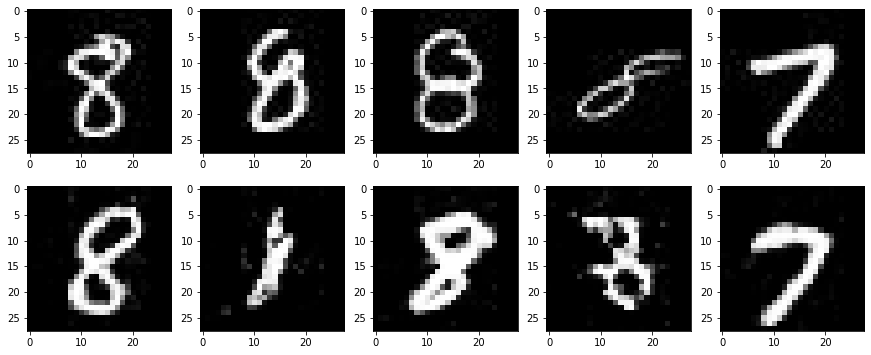

In [38]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


In [39]:
# テスト用のDataLoaderの作成


def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


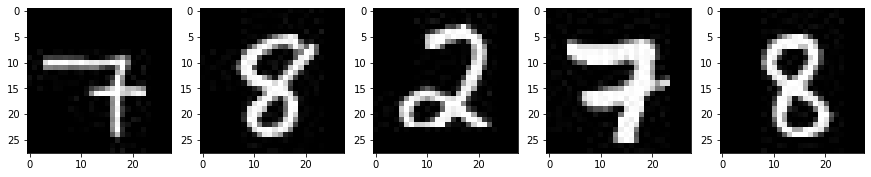

In [40]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [43]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


total loss： [190. 161. 281. 258. 142.]


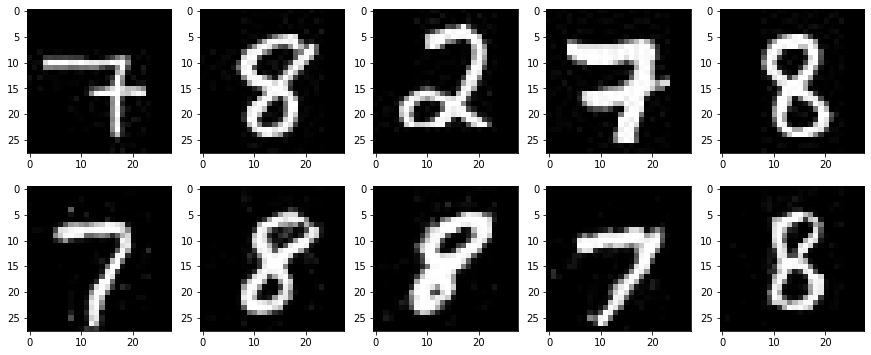

In [50]:
# 異常検知したい画像
# x = imges[0:5]
x = imges
x = x.to(device)

# 教師データの画像をエンコードしてzにしてから、Gで生成
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')


In [46]:
imges.size()

torch.Size([5, 1, 28, 28])

In [48]:
imges[0:5].size()

torch.Size([5, 1, 28, 28])